In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
info_job_level_dfs = {}
info_job_level_dfs["gpu_utilization"] = pd.read_csv("job_level_gpu_utilization.csv")
info_job_level_dfs["mem_copy_utilization"] = pd.read_csv("job_level_mem_copy_utilization.csv")
info_job_level_dfs["sm_active"] = pd.read_csv("job_level_sm_active.csv")

gputil_all = info_job_level_dfs["gpu_utilization"]

In [3]:
temporal_gpu_level_dfs = {}

temporal_gpu_level_dfs["gpu_utilization"] = pd.read_csv("temporal_gpu_level_gpu_utilization.csv")
temporal_gpu_level_dfs["mem_copy_utilization"] = pd.read_csv("temporal_gpu_level_mem_copy_utilization.csv")
temporal_gpu_level_dfs["sm_active"] = pd.read_csv("temporal_gpu_level_sm_active.csv")

In [4]:
spatial_job_level_dfs = {}

spatial_job_level_dfs["gpu_utilization"] = pd.read_csv("spatial_job_level_gpu_utilization.csv")
spatial_job_level_dfs["mem_copy_utilization"] = pd.read_csv("spatial_job_level_mem_copy_utilization.csv")
spatial_job_level_dfs["sm_active"] = pd.read_csv("spatial_job_level_sm_active.csv")

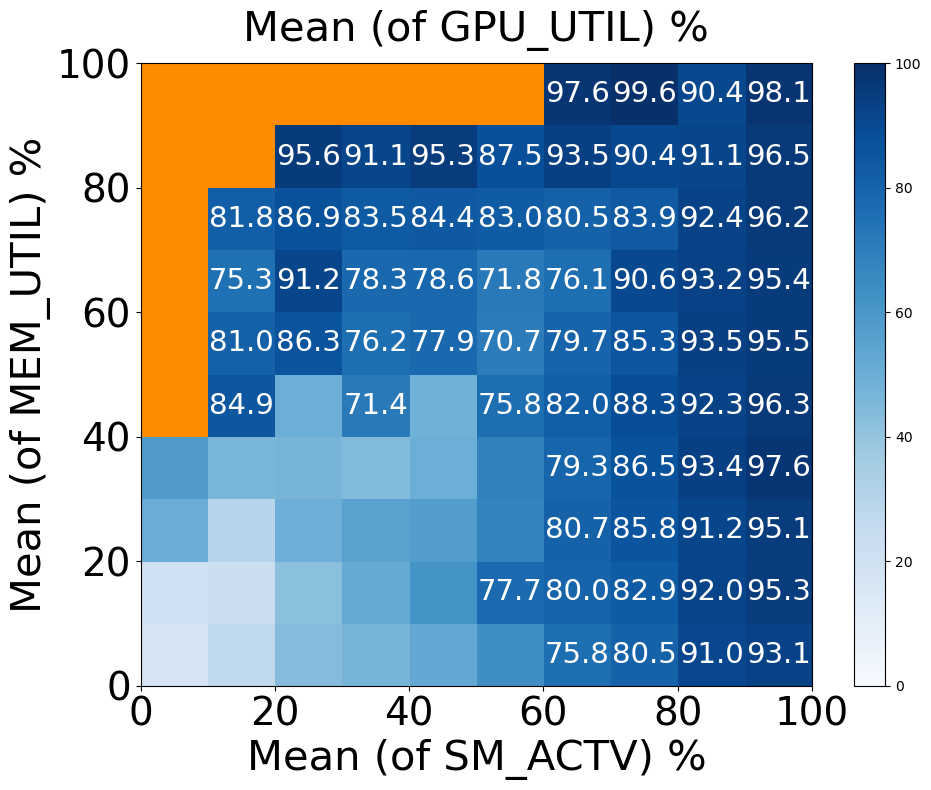

In [5]:
from matplotlib.colors import ListedColormap

gputil_all_grouped = info_job_level_dfs["gpu_utilization"].rename(columns={"mean_utilization": "mean_gpu_utilization"})
memcopy_df_grouped = info_job_level_dfs["mem_copy_utilization"].rename(columns={"mean_utilization": "mean_memcopy_utilization"})
sm_all_grouped = info_job_level_dfs["sm_active"].rename(columns={"mean_utilization": "mean_sm_active"})

sm_memcopy_mean = pd.merge(
    sm_all_grouped[["jobid", "mean_sm_active"]],
    memcopy_df_grouped[["jobid", "mean_memcopy_utilization"]],
    on='jobid',
    how='left'
)
sm_memcopy_mean_gputil = pd.merge(sm_memcopy_mean, gputil_all_grouped, on='jobid', how='right')
sm_memcopy_mean_gputil = sm_memcopy_mean_gputil.dropna(subset=["mean_memcopy_utilization"])
sm_memcopy_mean_gputil = sm_memcopy_mean_gputil.dropna(subset=["mean_sm_active"])

x = sm_memcopy_mean_gputil["mean_sm_active"]
y = sm_memcopy_mean_gputil["mean_memcopy_utilization"]
z = sm_memcopy_mean_gputil["mean_gpu_utilization"]

x_bins = np.linspace(0, 100, 11)
y_bins = np.linspace(0, 100, 11)

hist_sum, x_edges, y_edges = np.histogram2d(x, y, bins=[x_bins, y_bins], weights=z, density=False)
hist_squared_sum, _, _ = np.histogram2d(x, y, bins=[x_bins, y_bins], weights=z**2, density=False)
counts, _, _ = np.histogram2d(x, y, bins=[x_bins, y_bins])

mean_utilization = np.divide(hist_sum, counts, out=np.zeros_like(hist_sum), where=counts != 0)
std_utilization = np.sqrt(
    np.divide(hist_squared_sum, counts, out=np.zeros_like(hist_squared_sum), where=counts != 0) - mean_utilization**2
)
sem_utilization = np.divide(std_utilization, np.sqrt(counts), out=np.zeros_like(std_utilization), where=counts > 1)

plt.figure(figsize=(10, 8))
plt.imshow(
    mean_utilization.T,
    origin='lower',
    aspect='auto',
    extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]],
    cmap='Blues',
    vmin=0,
    vmax=100 
)
cbar = plt.colorbar()
plt.xlabel("Mean (of SM_ACTV) %", fontsize=30)
plt.ylabel("Mean (of MEM_UTIL) %", fontsize=30)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

for i in range(len(x_bins) - 1):
    for j in range(len(y_bins) - 1):
        x_center = x_bins[i] + (x_bins[1] - x_bins[0]) / 2
        y_center = y_bins[j] + (y_bins[1] - y_bins[0]) / 2
        if mean_utilization[i, j] > 70:
                    plt.text(
                        x_center,
                        y_center,
                        f"{mean_utilization[i, j]:.1f}",
                        color="white",
                        ha="center",
                        va="center",
                        fontsize=21
                    )
orange_cmap = ListedColormap(["#FF8C00"]) 
plt.imshow(
    np.where(counts.T == 0, -1, np.nan), 
    origin='lower',
    aspect='auto',
    extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]],
    cmap=orange_cmap,
    vmin=-1,
    vmax=0,
    alpha=1 
)

plt.title("Mean (of GPU_UTIL) %", pad=16, fontsize=30)
plt.tight_layout()
plt.show()

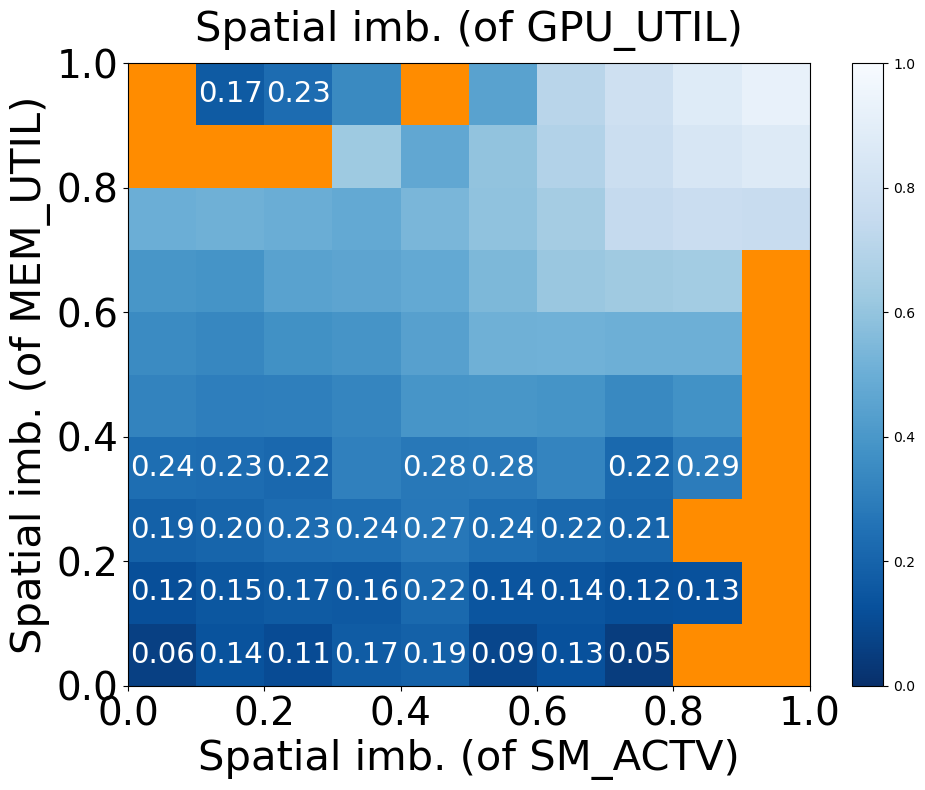

In [6]:
gputil_spatial = spatial_job_level_dfs["gpu_utilization"][["jobid", "spatial_imbalance_gpu_utilization"]]
memcopy_spatial = spatial_job_level_dfs["mem_copy_utilization"][["jobid", "spatial_imbalance_mem_copy_utilization"]]
sm_spatial = spatial_job_level_dfs["sm_active"][["jobid", "spatial_imbalance_sm_active"]]

sm_memcopy_spatial = pd.merge(
    sm_spatial,
    memcopy_spatial,
    on='jobid',
    how='left'
)

sm_memcopy_spatial_gputil = pd.merge(sm_memcopy_spatial, gputil_spatial, on='jobid', how='right')

sm_memcopy_spatial_gputil = sm_memcopy_spatial_gputil.dropna(subset=["spatial_imbalance_mem_copy_utilization"])
sm_memcopy_spatial_gputil = sm_memcopy_spatial_gputil.dropna(subset=["spatial_imbalance_sm_active"])

x = sm_memcopy_spatial_gputil["spatial_imbalance_sm_active"]
y = sm_memcopy_spatial_gputil["spatial_imbalance_mem_copy_utilization"]
z = sm_memcopy_spatial_gputil["spatial_imbalance_gpu_utilization"]

x_bins = np.linspace(0, 1, 11)
y_bins = np.linspace(0, 1, 11)

hist_sum, x_edges, y_edges = np.histogram2d(x, y, bins=[x_bins, y_bins], weights=z, density=False)
hist_squared_sum, _, _ = np.histogram2d(x, y, bins=[x_bins, y_bins], weights=z**2, density=False)
counts, _, _ = np.histogram2d(x, y, bins=[x_bins, y_bins])  # Count of points in each bin

mean_utilization = np.divide(hist_sum, counts, out=np.zeros_like(hist_sum), where=counts != 0)
std_utilization = np.sqrt(
    np.divide(hist_squared_sum, counts, out=np.zeros_like(hist_squared_sum), where=counts != 0) - mean_utilization**2
)
sem_utilization = np.divide(std_utilization, np.sqrt(counts), out=np.zeros_like(std_utilization), where=counts > 1)

mean_utilization_with_nan = np.where(counts == 0, np.nan, mean_utilization)

plt.figure(figsize=(10, 8))
plt.imshow(
    mean_utilization_with_nan.T, 
    origin='lower', 
    aspect='auto', 
    extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]], 
    cmap='Blues_r', 
    vmin=0, 
    vmax=1
)
cbar = plt.colorbar()
plt.xlabel("Spatial imb. (of SM_ACTV)", fontsize=30)
plt.ylabel("Spatial imb. (of MEM_UTIL)", fontsize=30)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

for i in range(len(x_bins) - 1):
    for j in range(len(y_bins) - 1):
        # Center of the bin
        x_center = x_bins[i] + (x_bins[1] - x_bins[0]) / 2
        y_center = y_bins[j] + (y_bins[1] - y_bins[0]) / 2

        if mean_utilization_with_nan[i, j] < 0.3: 
                    plt.text(
                        x_center,
                        y_center,
                        f"{mean_utilization_with_nan[i, j]:.2f}",
                        color="white",
                        ha="center",
                        va="center",
                        fontsize=21
                    )

plt.imshow(
    np.where(counts.T == 0, -1, np.nan), 
    origin='lower', 
    aspect='auto', 
    extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]], 
    cmap=orange_cmap, 
    vmin=-1, 
    vmax=0, 
    alpha=1
)

plt.title("Spatial imb. (of GPU_UTIL)", pad=16, fontsize=30)
plt.tight_layout()
plt.show()

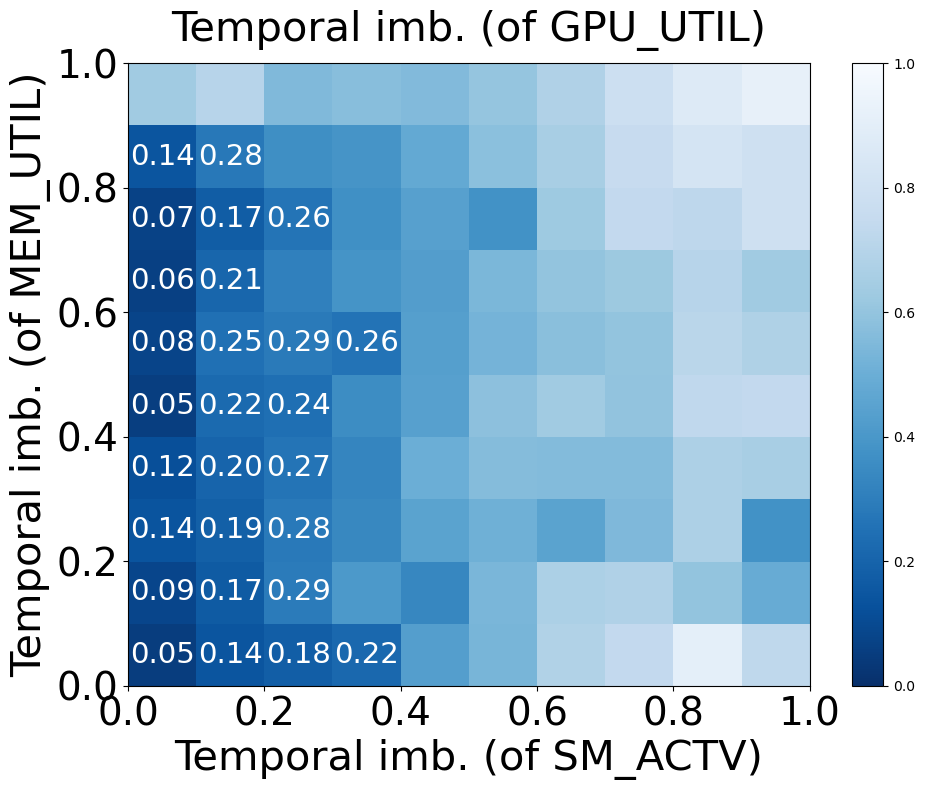

In [7]:
gputil_temporal_grouped = temporal_gpu_level_dfs["gpu_utilization"].groupby("jobid").agg({"temporal_imbalance" : 'max'}).reset_index()
memcopy_temporal_grouped = temporal_gpu_level_dfs["mem_copy_utilization"].groupby("jobid").agg({"temporal_imbalance" : 'max'}).reset_index()
sm_temporal_grouped = temporal_gpu_level_dfs["sm_active"].groupby("jobid").agg({"temporal_imbalance" : 'max'}).reset_index()

gputil_temporal_grouped = gputil_temporal_grouped.rename(columns={"temporal_imbalance": "temporal_imbalance_gputil"})
memcopy_temporal_grouped = memcopy_temporal_grouped.rename(columns={"temporal_imbalance": "temporal_imbalance_memcopy"})
sm_temporal_grouped = sm_temporal_grouped.rename(columns={"temporal_imbalance": "temporal_imbalance_sm"})

sm_memcopy_temporal = pd.merge(
    sm_temporal_grouped[["jobid", "temporal_imbalance_sm"]],
    memcopy_temporal_grouped[["jobid", "temporal_imbalance_memcopy"]],
    on='jobid',
    how='left'
)

sm_memcopy_temporal_gputil = pd.merge(sm_memcopy_temporal, gputil_temporal_grouped, on='jobid', how='right')

sm_memcopy_temporal_gputil = sm_memcopy_temporal_gputil.dropna(subset=["temporal_imbalance_memcopy"])
sm_memcopy_temporal_gputil = sm_memcopy_temporal_gputil.dropna(subset=["temporal_imbalance_sm"])

x = sm_memcopy_temporal_gputil["temporal_imbalance_sm"]
y = sm_memcopy_temporal_gputil["temporal_imbalance_memcopy"]
z = sm_memcopy_temporal_gputil["temporal_imbalance_gputil"]

x_bins = np.linspace(0, 1, 11) 
y_bins = np.linspace(0, 1, 11) 

hist_sum, x_edges, y_edges = np.histogram2d(x, y, bins=[x_bins, y_bins], weights=z, density=False)
hist_squared_sum, _, _ = np.histogram2d(x, y, bins=[x_bins, y_bins], weights=z**2, density=False)
counts, _, _ = np.histogram2d(x, y, bins=[x_bins, y_bins]) 

mean_temporal_imbalance = np.divide(hist_sum, counts, out=np.zeros_like(hist_sum), where=counts != 0)
std_temporal_imbalance = np.sqrt(
    np.divide(hist_squared_sum, counts, out=np.zeros_like(hist_squared_sum), where=counts != 0) - mean_temporal_imbalance**2
)
sem_temporal_imbalance = np.divide(std_temporal_imbalance, np.sqrt(counts), out=np.zeros_like(std_temporal_imbalance), where=counts > 1)

plt.figure(figsize=(10, 8))
plt.imshow(
    mean_temporal_imbalance.T,
    origin='lower',
    aspect='auto',
    extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]],
    cmap='Blues_r',
    vmin=0,
    vmax=1
)
cbar = plt.colorbar()
plt.xlabel("Temporal imb. (of SM_ACTV)", fontsize=30)
plt.ylabel("Temporal imb. (of MEM_UTIL)", fontsize=30)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
for i in range(len(x_bins) - 1):
    for j in range(len(y_bins) - 1):
        x_center = x_bins[i] + (x_bins[1] - x_bins[0]) / 2
        y_center = y_bins[j] + (y_bins[1] - y_bins[0]) / 2

        if mean_temporal_imbalance[i, j] < 0.3:
                    plt.text(
                        x_center,
                        y_center,
                        f"{mean_temporal_imbalance[i, j]:.2f}",
                        color="white",
                        ha="center",
                        va="center",
                        fontsize=21
                    )

plt.imshow(
    np.where(counts.T == 0, -1, np.nan),
    origin='lower',
    aspect='auto',
    extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]],
    cmap=orange_cmap,
    vmin=-1,
    vmax=0,
    alpha=1
)

plt.title("Temporal imb. (of GPU_UTIL)", pad=16, fontsize=30)
plt.tight_layout()
plt.show()